In [1]:
!pip install --upgrade gspread gspread-dataframe --quiet
!pip install evaluate --quiet
!pip install rouge_score --quiet
!pip install bert-score --quiet
!python -m spacy download en_core_web_lg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.

In [2]:
import numpy as np
import pandas as pd
import regex as re
import time
from google.colab import files
from google.colab import drive
import json

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

!pip install altair_data_server --quiet
import altair as alt
from altair_data_server import data_server

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
from gspread_dataframe import set_with_dataframe
from gspread_dataframe import get_as_dataframe

# Mount drive and read input files [update path based on user]
drive.mount('/content/drive')

import evaluate
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [3]:
import logging

# Suppress warnings from the transformers library
logging.getLogger("transformers").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="spacy")
warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

In [4]:
# Output data sheet
# output_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1SMNfXb56igoyJx3vT-YFNqzgFmBbkn73xgDPatBBAAM/edit?gid=0#gid=0') # T5-Small
output_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1BWEHnuRuwHRpkSL_06Rx26p4TktH_vul4bVg_DMBYKw/edit?gid=0#gid=0') #T5-Large
output_workesheet = output_spreadsheet.get_worksheet(0)

In [5]:
# Read in Training data
training_data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1YcGOvY4HN6o1Dt5Q8R3yzSolkfKnT9dHPm9iCqXJTe4/edit?gid=457380158#gid=457380158')
training_data_worksheet = training_data_spreadsheet.get_worksheet(0)
training_data_df = get_as_dataframe(training_data_worksheet, evaluate_formulas=True)

# Only train on data that has a paraphrase - blanks are not useful
training_data_df = training_data_df[training_data_df['paraphrase'].isna()==False].reset_index(drop=True)

print(len(training_data_df))
training_data_df.head()

4784


,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label
0,1588.0,Coinbase,CB Payments & COINBASE UK PRIVACY POLICY,"With law enforcement, officials, or other thir...","With law enforcement, officials, or other thir...",This service reserves the right to disclose yo...,1.0
1,831.0,Clockify,Terms of Use,AGREEMENT AMENDMENTS COING may revise and upda...,Any changes shall enter into force upon being ...,"When the service wants to change its terms, us...",1.0
2,1593.0,ISODME,Privacy Policy,Tracking technologies and Cookies. We use cook...,"We use cookies, beacons, tags, scripts and oth...","The service may use tracking pixels, web beaco...",1.0
3,185.0,Netflix,Terms of Use,The member who created the Netflix account and...,You are responsible for updating and maintaini...,"You must provide your legal name, pseudonyms a...",1.0
4,836.0,Scratch,"Privacy Policy (February 14, 2019)",Parents and guardians who register their under...,The results of this research are shared with e...,Your personal data is aggregated into statistics,1.0


In [6]:
# Read in test data
test_data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Uho60wnU9C-cLqUBC3VM4v0Q_S9I4DRMvmcEspdK4U8/edit?gid=338078967#gid=338078967')
test_data_worksheet = test_data_spreadsheet.get_worksheet(0)
test_data_df = get_as_dataframe(test_data_worksheet, evaluate_formulas=True)

# Train T5 Model

In [ ]:
saved_model_path = "/content/drive/MyDrive/266 Final Project/Stage 2/model"

In [ ]:
class ParaphraseDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        highlight = str(self.data.loc[index, 'highlight'])
        paraphrase = str(self.data.loc[index, 'paraphrase'])

        inputs = self.tokenizer(
            "paraphrase: " + highlight,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        targets = self.tokenizer(
            paraphrase,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }

# Train from scratch and save
def train_and_save(dataframe, save_path, model_name="t5-large"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    dataset = ParaphraseDataset(dataframe, tokenizer)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_strategy="steps",
        logging_steps=10,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset
    )

    trainer.train()

    # Save the model and tokenizer
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model and tokenizer saved to {save_path}")

# Continue training from saved model
def continue_training(dataframe, save_path):
    tokenizer = T5Tokenizer.from_pretrained(save_path)
    model = T5ForConditionalGeneration.from_pretrained(save_path)
    dataset = ParaphraseDataset(dataframe, tokenizer)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_strategy="steps",
        logging_steps=10,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset
    )

    trainer.train()

    # Save the updated model
    model.save_pretrained(save_path)
    print(f"Model updated and saved to {save_path}")

In [ ]:
# Training

## Train from scratch and save
train_and_save(training_data_df, saved_model_path)

## Continue training from saved model
# continue_training(highlights_df, saved_model_path)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

{'loss': 23.3628, 'grad_norm': 82.38313293457031, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.008361204013377926}
{'loss': 20.1036, 'grad_norm': 112.62042999267578, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.016722408026755852}
{'loss': 21.0667, 'grad_norm': 115.13167572021484, 'learning_rate': 3e-06, 'epoch': 0.02508361204013378}
{'loss': 17.1967, 'grad_norm': 117.81287384033203, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.033444816053511704}
{'loss': 15.3251, 'grad_norm': 127.61785125732422, 'learning_rate': 5e-06, 'epoch': 0.04180602006688963}
{'loss': 13.6857, 'grad_norm': 188.13551330566406, 'learning_rate': 6e-06, 'epoch': 0.05016722408026756}
{'loss': 11.9862, 'grad_norm': 88.72176361083984, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.05852842809364549}
{'loss': 9.9815, 'grad_norm': 104.54273986816406, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.06688963210702341}
{'loss': 8.5248, 'grad_norm': 113.36637878417969, 'learning_rate': 9e-06, 'epo

# T5 Model

In [ ]:
# Load a pre-trained model and use it
def paraphrase_text(input_text, segment_name = "policy", save_path = saved_model_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = T5Tokenizer.from_pretrained(save_path)
    model = T5ForConditionalGeneration.from_pretrained(save_path).to(device)

    inputs = tokenizer(
        f"paraphrase this {segment_name} statement: {input_text}",
        return_tensors="pt",
        max_length=128,
        truncation=True
    ).to(device)

    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# GPT Model

In [ ]:
import openai

In [ ]:
import os
from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY'),
)

In [ ]:
training_data_df.head()

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label
0,1588.0,Coinbase,CB Payments & COINBASE UK PRIVACY POLICY,"With law enforcement, officials, or other thir...","With law enforcement, officials, or other thir...",This service reserves the right to disclose yo...,1.0
1,831.0,Clockify,Terms of Use,AGREEMENT AMENDMENTS COING may revise and upda...,Any changes shall enter into force upon being ...,"When the service wants to change its terms, us...",1.0
2,1593.0,ISODME,Privacy Policy,Tracking technologies and Cookies. We use cook...,"We use cookies, beacons, tags, scripts and oth...","The service may use tracking pixels, web beaco...",1.0
3,185.0,Netflix,Terms of Use,The member who created the Netflix account and...,You are responsible for updating and maintaini...,"You must provide your legal name, pseudonyms a...",1.0
4,836.0,Scratch,"Privacy Policy (February 14, 2019)",Parents and guardians who register their under...,The results of this research are shared with e...,Your personal data is aggregated into statistics,1.0


In [ ]:
gpt_training_data_df = training_data_df[['doc_type', 'highlight', 'paraphrase']][:100]
gpt_training_data_df.head()

,doc_type,highlight,paraphrase
0,CB Payments & COINBASE UK PRIVACY POLICY,"With law enforcement, officials, or other thir...",This service reserves the right to disclose yo...
1,Terms of Use,Any changes shall enter into force upon being ...,"When the service wants to change its terms, us..."
2,Privacy Policy,"We use cookies, beacons, tags, scripts and oth...","The service may use tracking pixels, web beaco..."
3,Terms of Use,You are responsible for updating and maintaini...,"You must provide your legal name, pseudonyms a..."
4,"Privacy Policy (February 14, 2019)",The results of this research are shared with e...,Your personal data is aggregated into statistics


In [ ]:
gpt_test_data_df = test_data_df[test_data_df['paraphrase'].isna()==False].reset_index(drop=True)
gpt_test_data_df = gpt_test_data_df[['doc_type', 'highlight', 'paraphrase']][:20]
gpt_test_data_df.head()

,doc_type,highlight,paraphrase
0,Privacy Policy,You should not share your credentials with thi...,You are responsible for maintaining the securi...
1,Terms & Conditions,You are fully responsible for all activities t...,You are responsible for maintaining the securi...
2,Terms of Service,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time
3,Terms of Service,We have the right to terminate your membership...,Your account can be deleted without prior noti...
4,Privacy Policy,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...


In [ ]:
with open("gpt_train_data.jsonl", "w") as f:
    for _, row in gpt_training_data_df.iterrows():
        chat_data = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant trained to paraphrase text while maintaining the same meaning and staying very concise."},
                {"role": "user", "content": f"Paraphrase the following {row['doc_type']} text:\n\n{row['highlight']}"},
                {"role": "assistant", "content": row["paraphrase"]}
            ]
        }
        json.dump(chat_data, f)
        f.write("\n")

with open("gpt_test_data.jsonl", "w") as f:
    for _, row in gpt_test_data_df.iterrows():
        chat_data = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant trained to paraphrase text while maintaining the same meaning and staying very concise."},
                {"role": "user", "content": f"Paraphrase the following {row['doc_type']} text:\n\n{row['highlight']}"},
                {"role": "assistant", "content": row["paraphrase"]}
            ]
        }
        json.dump(chat_data, f)
        f.write("\n")

In [ ]:
train_file = client.files.create(
    file=open("gpt_train_data.jsonl", "rb"),
    purpose='fine-tune'
)

print(f"Training file Info: {train_file}")

test_file = client.files.create(
    file=open("gpt_test_data.jsonl", "rb"),
    purpose='fine-tune'
)

print(f"Test file Info: {test_file}")

Training file Info: FileObject(id='file-B9hr4R1C3HauWfNTsmgvwB', bytes=51050, created_at=1733382688, filename='gpt_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [ ]:
gpt_model = client.fine_tuning.jobs.create(
  training_file=train_file.id,
  validation_file=test_file.id,
  model="gpt-4o-mini-2024-07-18",
  hyperparameters={
    "n_epochs": 3,
	"batch_size": 3,
	"learning_rate_multiplier": 0.3
  }
)
job_id = gpt_model.id
status = gpt_model.status

print(f'Fine-tuning model with jobID: {job_id}.')
print(f"Training Response: {gpt_model}")
print(f"Training Status: {status}")

Fine-tuning model with jobID: ftjob-gwv51LHPX4PRXWvHid1WzCZ5.
Training Response: FineTuningJob(id='ftjob-gwv51LHPX4PRXWvHid1WzCZ5', created_at=1733382694, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=3, learning_rate_multiplier=0.3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-G3FrwW2OwlXdLyfDgiqCQHWy', result_files=[], seed=641383576, status='validating_files', trained_tokens=None, training_file='file-B9hr4R1C3HauWfNTsmgvwB', validation_file='file-SKFV2eCGSmM6jsvj1p3MaX', estimated_finish=None, integrations=[], user_provided_suffix=None)
Training Status: validating_files


In [ ]:
gpt_models = client.fine_tuning.jobs.list()
print(gpt_models)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-gwv51LHPX4PRXWvHid1WzCZ5', created_at=1733382694, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=3, learning_rate_multiplier=0.3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-G3FrwW2OwlXdLyfDgiqCQHWy', result_files=[], seed=641383576, status='validating_files', trained_tokens=None, training_file='file-B9hr4R1C3HauWfNTsmgvwB', validation_file='file-SKFV2eCGSmM6jsvj1p3MaX', estimated_finish=None, integrations=[], user_provided_suffix=None), FineTuningJob(id='ftjob-vcCAYh8UPaznhiq1465R6s4N', created_at=1733382514, error=Error(code='invalid_training_file', message='The job failed due to an invalid training file. Invalid file format. Input file file-1ynkaQwsBxga715ybkRTcS is in the prompt-completion format, but the specified model gpt-4o-mini-2024-07-18 is a chat model and requires chat-formatted dat

In [ ]:
gpt_fine_tuned_model = gpt_models.data[0].gpt_fine_tuned_model
print(gpt_fine_tuned_model)

In [ ]:
def generate_paraphrase_with_gpt(original_text, segment_name="policy"):
    """
    Use OpenAI's GPT model to generate a paraphrase for the given text.
    """
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant trained to paraphrase text while maintaining the same meaning and staying very concise.",
        },
        {
            "role": "user",
            "content": f"Paraphrase the following {segment_name} text:\n\n{original_text}",
        }
    ]

    try:
        response = client.chat.completions.create(
            model="ft:gpt-4o-mini-2024-07-18:personal::Ab0VpOaw",
            messages=messages,
            max_tokens=128,
            temperature=0.9,
        )

        paraphrase = response.choices[0].message.content.strip()
        return paraphrase
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Test Data

In [ ]:
################ GET TEST DATA ########################
test_data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Uho60wnU9C-cLqUBC3VM4v0Q_S9I4DRMvmcEspdK4U8/edit?gid=338078967#gid=338078967')
test_data_worksheet = test_data_spreadsheet.get_worksheet(0)
test_data_df = get_as_dataframe(test_data_worksheet, evaluate_formulas=True)

test_data_df = test_data_df[test_data_df['paraphrase'].isna()==False].reset_index(drop=True)
test_data_df = test_data_df.drop(columns=['label'])

print(len(test_data_df))
test_data_df.head()

1196


,service_id,service_name,doc_type,doc_text,highlight,paraphrase
0,264.0,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...
1,616.0,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...
2,403.0,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time
3,2947.0,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...
4,2544.0,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...


In [ ]:
# Example usage
index = 3
print("Original Highlight:", test_data_df['highlight'][index],  "\n")
# print("Generated Paraphrase:", paraphrase_text(test_data_df['highlight'][index], test_data_df['doc_type'][index]), "\n")
print("GPT Paraphrase:", generate_paraphrase_with_gpt(test_data_df['highlight'][index], test_data_df['doc_type'][index]), "\n")

Original Highlight: We have the right to terminate your membership, account, payment, or other affiliation with the Service at any time and for any reason. 

[{'role': 'system', 'content': 'You are a helpful assistant trained to paraphrase text while maintaining the same meaning and staying very concise.'}, {'role': 'user', 'content': 'Paraphrase the following Terms of Service text:\n\nWe have the right to terminate your membership, account, payment, or other affiliation with the Service at any time and for any reason.'}]
GPT Paraphrase: The service is allowed to cancel your account for no reason 



In [ ]:
nlp = spacy.load("en_core_web_lg")
rouge = evaluate.load("rouge")

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method1

In [ ]:
for index, row in test_data_df.iterrows():
    original_highlight = row['highlight']
    segment_name = row['doc_type']
    gpt_generated = "False"

    # Generate paraphrase using your paraphrasing function
    generated_paraphrase = paraphrase_text(original_highlight, segment_name)

    # Calculate BERTScore
    P, R, F1 = score(
        [generated_paraphrase],
        [original_highlight],
        lang="en"
    )
    bert_score = F1.item()

    # Calculate ROUGE scores
    rouge_score = rouge.compute(
        predictions=[generated_paraphrase],
        references=[original_highlight]
    )

    # Calculate BLEU score with smoothing
    bleu_score = sentence_bleu(
        [original_highlight.split()],
        generated_paraphrase.split(),
        smoothing_function=smooth_fn
    )

    # Calculate spaCy similarity
    original_doc = nlp(original_highlight)
    generated_doc = nlp(generated_paraphrase)
    spacy_similarity = original_doc.similarity(generated_doc)

    # Retry with GPT if BERTScore is below 0.75
    if bert_score < 0.75:
        gpt_generated_paraphrase = generate_paraphrase_with_gpt(original_highlight, segment_name)

        # Recalculate BERTScore
        P, R, F1 = score(
            [gpt_generated_paraphrase],
            [original_highlight],
            lang="en"
        )
        gpt_bert_score = F1.item()

        # Compare GPT-generated paraphrase with original
        print("\n\n")
        print(f"original_highlight: {original_highlight}")
        print(f"generated_paraphrase: {generated_paraphrase}")
        print(f"BERTScore: {bert_score}")
        print(f"gpt_generated_paraphrase: {gpt_generated_paraphrase}")
        print(f"gpt_BERTScore: {gpt_bert_score}")
        print("\n")

        if gpt_bert_score > bert_score:
            generated_paraphrase = gpt_generated_paraphrase
            bert_score = gpt_bert_score
            gpt_generated = "True"
            print("Using GPT paraphrase")

    # Store results in the DataFrame
    test_data_df.at[index, 'generated_paraphrase'] = generated_paraphrase
    test_data_df.at[index, 'bert_score'] = bert_score
    test_data_df.at[index, 'rouge_1'] = rouge_score['rouge1']
    test_data_df.at[index, 'rouge_2'] = rouge_score['rouge2']
    test_data_df.at[index, 'rouge_l'] = rouge_score['rougeL']
    test_data_df.at[index, 'bleu_score'] = bleu_score
    test_data_df.at[index, 'spacy_similarity'] = spacy_similarity
    test_data_df.at[index, 'gpt_generated'] = gpt_generated

    # Push to Google Sheets every 25 rows
    if index % 25 == 0 and index != 0:
        set_with_dataframe(output_workesheet, test_data_df)
        time.sleep(10)

# Final push to Google Sheets
set_with_dataframe(output_workesheet, test_data_df)




original_highlight: Daneben knnen wir gesetzlich verpflichtet sein, Daten im Einzelfall auf Anordnung einer zustndigen
Stelle weiterzugeben, wenn und soweit dies fr Zwecke der Strafverfolgung, zur Gefahrenabwehr durch
die Polizeibehrden der Lnder, zur Erfllung der gesetzlichen Aufgaben der
Verfassungsschutzbehrden des Bundes und der Lnder, des Bundesnachrichtendienstes oder des
Militrischen Abschirmdienstes oder des Bundeskriminalamtes im Rahmen seiner Aufgabe zur Abwehr von
Gefahren des internationalen Terrorismus oder zur Durchsetzung der Rechte am geistigen Eigentum
erforderlich ist.
generated_paraphrase: This service reserves the right to disclose your personal information without notifying you
BERTScore: 0.7387959957122803
gpt_generated_paraphrase: Wir können gesetzlich verpflichtet sein, Daten auf Anordnung zuständiger Stellen weiterzugeben, wenn dies zur Strafverfolgung, Gefahrenabwehr durch Polizeibehörden, zur Erfüllung der Aufgaben von Verfassungsschutzbehörden, des Bundes

In [ ]:
test_data_df.head()

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,generated_paraphrase,bert_score,rouge_1,rouge_2,rouge_l,bleu_score,spacy_similarity,gpt_generated
0,264.0,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,You cannot distribute or disclose your account...,0.881103,0.312500,0.066667,0.250000,0.016904,0.887373,False
1,616.0,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...,You are responsible for maintaining the securi...,0.907655,0.375000,0.133333,0.375000,0.038071,0.859078,False
2,403.0,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time,They may stop providing the service at any time,0.879164,0.222222,0.117647,0.222222,0.007595,0.845388,False
3,2947.0,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...,They may stop providing the service at any time,0.880075,0.312500,0.266667,0.312500,0.026919,0.908345,False
4,2544.0,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...,"You can request access, correction and/or dele...",0.780810,0.000000,0.000000,0.000000,0.000000,0.015450,False


# Evaluation

## Rouge

In [9]:
# Load the metric
rouge = evaluate.load("rouge")

# Compute ROUGE scores
results = rouge.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

print(results)

{'rouge1': 0.5600182804482583, 'rouge2': 0.4654325449958723, 'rougeL': 0.5454295666430626, 'rougeLsum': 0.5447955819466669}


*	ROUGE-1: Measures unigram (word-level) overlap.
  *	Good range: 0.4–0.6 or higher.
*	ROUGE-2: Measures bigram (two-word sequence) overlap.
  *	Good range: 0.2–0.4 or higher.
*	ROUGE-L: Measures the longest common subsequence (focuses on fluency and structure).
  *	Good range: 0.3–0.5 or higher.

## Bleu

In [10]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Smoothing function
smooth_fn = SmoothingFunction().method1

# Prepare tokenized references and candidates
references = [[ref.split()] for ref in results_df['paraphrase'].tolist()]
candidates = [str(cand).split() for cand in results_df['generated_paraphrase'].tolist()]

# Compute BLEU score
overall_bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth_fn)

# Print the overall BLEU score
print(f"Overall BLEU Score: {overall_bleu_score:.4f}")

Overall BLEU Score: 0.4465


## Mereor

In [11]:
# Load METEOR metric
meteor = evaluate.load("meteor")

# Compute METEOR scores
results = meteor.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

# Print the results
print(results)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.5358034880687724}


## BERT

In [12]:
from bert_score import score

P, R, F1 = score(
    results_df['generated_paraphrase'].astype(str).tolist(),
    results_df['paraphrase'].astype(str).tolist(),
    lang="en"
)

results_df['BERTScore P<>GP'] = F1.numpy()

overall_bert_score = F1.mean().item()
print(f"Overall BERTScore P<>GP (F1): {overall_bert_score:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Overall BERTScore P<>GP (F1): 0.9236


## SpaCy
fact checking

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_age(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "CARDINAL":  # Check for cardinal numbers
            return ent.text
    return None

highlight = "You are at least 13 years old."
generated_paraphrase = "You are 18 years old."

highlight_age = extract_age(highlight)
generated_age = extract_age(generated_paraphrase)

if highlight_age != generated_age:
    print("Factual inconsistency detected!")
else:
    print("Paraphrase is consistent.")

In [13]:
import spacy

# Load the spaCy model (use a model with word vectors, e.g., 'en_core_web_md' or 'en_core_web_lg')
nlp = spacy.load("en_core_web_lg")

# Ensure all values are strings
generated_paraphrases = results_df['generated_paraphrase'].astype(str).tolist()
paraphrases = results_df['paraphrase'].astype(str).tolist()

# Calculate spaCy similarity for each pair
spacy_scores = []

for gen, ref in zip(generated_paraphrases, paraphrases):
    gen_doc = nlp(gen)
    ref_doc = nlp(ref)
    similarity = gen_doc.similarity(ref_doc)
    spacy_scores.append(similarity)

# Add individual spaCy scores to the DataFrame
results_df['spaCy Similarity'] = spacy_scores

# Compute the overall spaCy similarity score
overall_spacy_score = sum(spacy_scores) / len(spacy_scores)

print(f"Overall spaCy Similarity Score: {overall_spacy_score:.4f}")

Overall spaCy Similarity Score: 0.8802


# Analysis

In [20]:
data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/12C-A9wGs-5snsP5_P9kKj0iZzXZS5cr0lBL-AhMX8Qc/edit?gid=0#gid=0")
mapping_ws = data_spreadsheet.worksheet("Type Mapping")
mapping_df = get_as_dataframe(mapping_ws, evaluate_formulas=True)
mapping_df.head()

,segment_name,segment_type
0,Content Policy,Other
1,Digital Millennium Copyright Act (DMCA) Notic...,Other
2,Terms and Conditions,Terms
3,2FA,Other
4,About Cookies,Cookie Policy


In [ ]:
gen_analysis_df = gen_improved_data_df.merge(mapping_df, on="segment_name", how="left")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

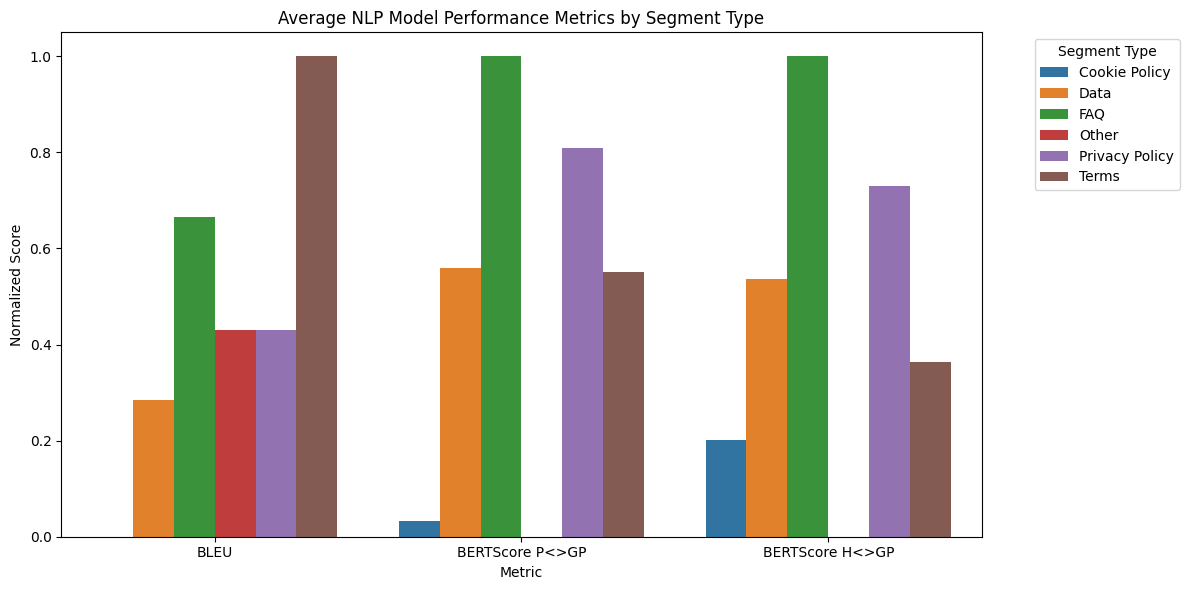

In [ ]:
# Group the data by segment_name and calculate mean scores
grouped_segment_df = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Normalize scores for better visualization
grouped_segment_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]] = scaler.fit_transform(
    grouped_segment_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]]
)

# Melt the DataFrame for easier plotting
melted_segment_df = grouped_segment_df.melt(
    id_vars=["segment_type"],
    value_vars=["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"],
    var_name="Metric",
    value_name="Score"
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_segment_df, x="Metric", y="Score", hue="segment_type")

plt.title("Average NLP Model Performance Metrics by Segment Type")
plt.xlabel("Metric")
plt.ylabel("Normalized Score")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

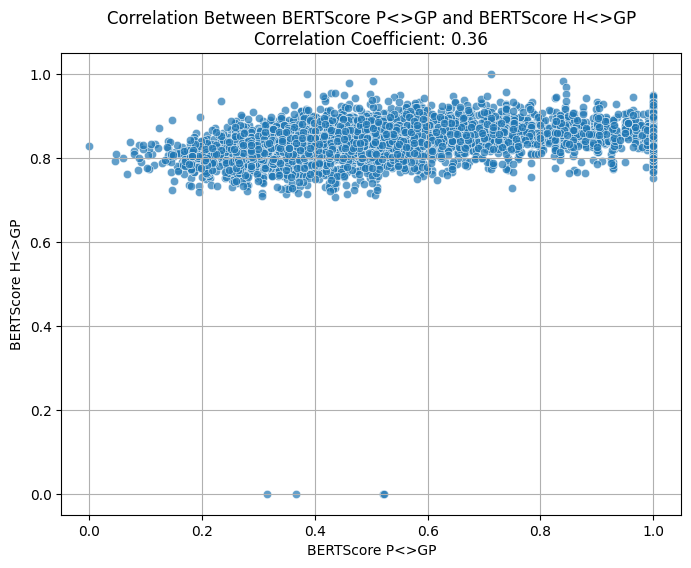

In [ ]:
# Calculate correlation between the two BERT scores
correlation = gen_analysis_df["BERTScore P<>GP"].corr(gen_analysis_df["BERTScore H<>GP"])

# Plot correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gen_analysis_df, x="BERTScore P<>GP", y="BERTScore H<>GP", alpha=0.7)
plt.title(f"Correlation Between BERTScore P<>GP and BERTScore H<>GP\nCorrelation Coefficient: {correlation:.2f}")
plt.xlabel("BERTScore P<>GP")
plt.ylabel("BERTScore H<>GP")
plt.grid(True)
plt.show()

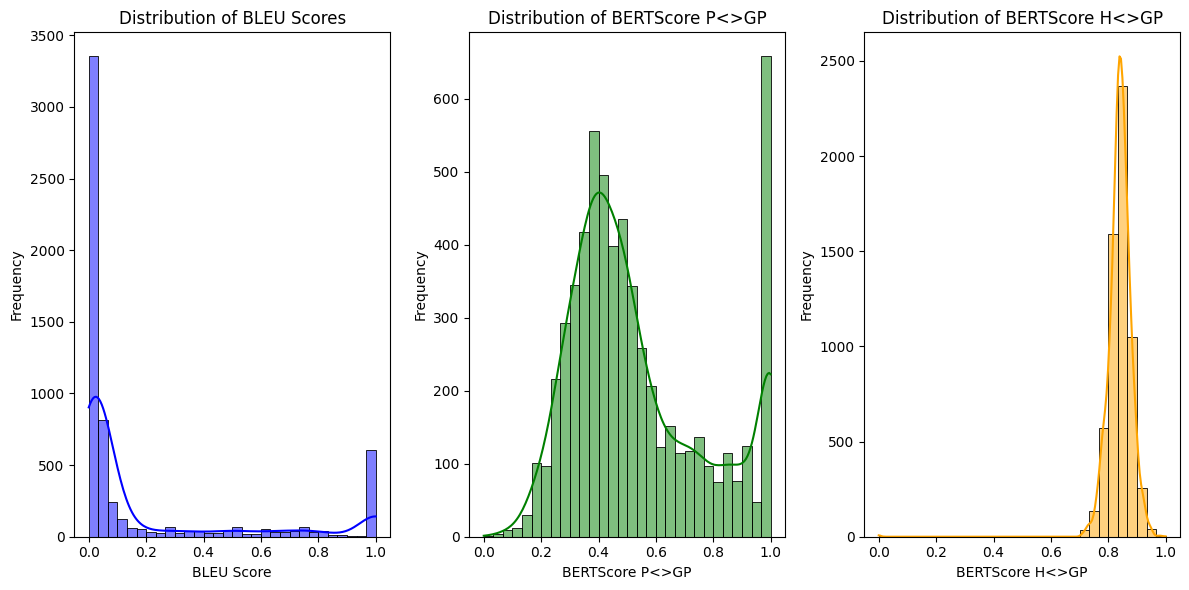

In [ ]:
# Plot the distribution of BLEU and BERT scores
plt.figure(figsize=(12, 6))

# BLEU Score Distribution
plt.subplot(1, 3, 1)
sns.histplot(gen_analysis_df["BLEU"], kde=True, bins=30, color="blue")
plt.title("Distribution of BLEU Scores")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")

# BERTScore P<>GP Distribution
plt.subplot(1, 3, 2)
sns.histplot(gen_analysis_df["BERTScore P<>GP"], kde=True, bins=30, color="green")
plt.title("Distribution of BERTScore P<>GP")
plt.xlabel("BERTScore P<>GP")
plt.ylabel("Frequency")

# BERTScore H<>GP Distribution
plt.subplot(1, 3, 3)
sns.histplot(gen_analysis_df["BERTScore H<>GP"], kde=True, bins=30, color="orange")
plt.title("Distribution of BERTScore H<>GP")
plt.xlabel("BERTScore H<>GP")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

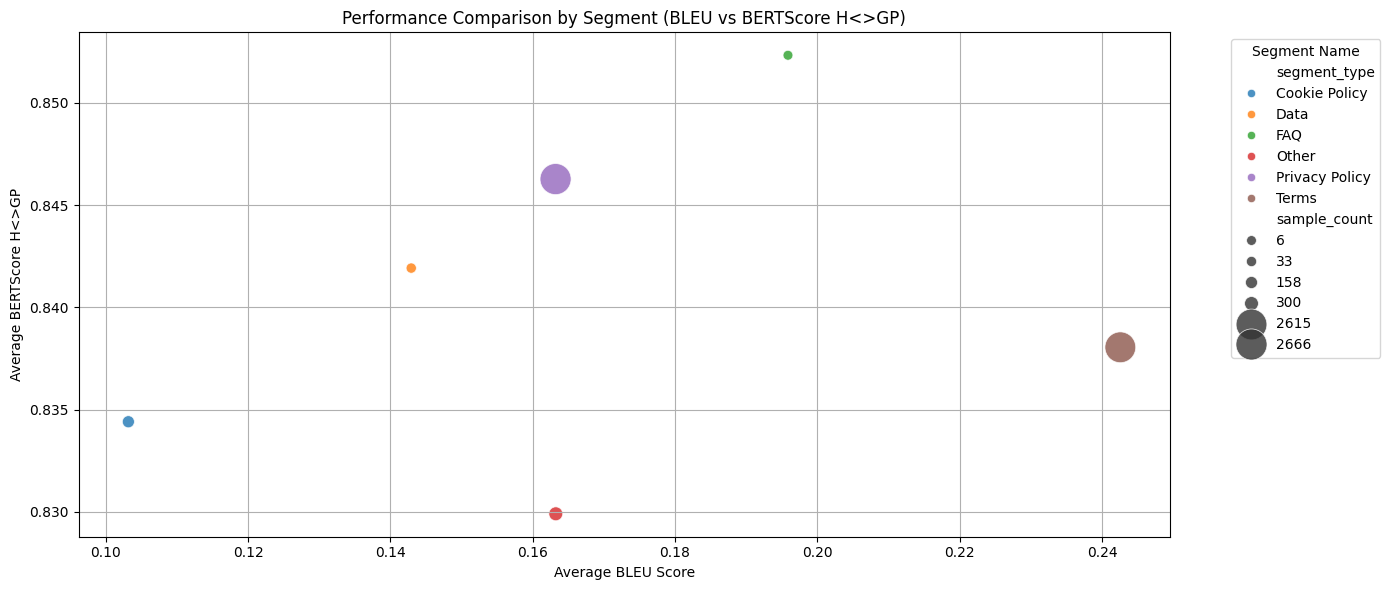

In [ ]:
# Count the number of rows (samples) per segment_name
segment_sample_counts = gen_analysis_df["segment_type"].value_counts().reset_index()
segment_sample_counts.columns = ["segment_type", "sample_count"]

# Calculate the mean scores for each segment
segment_performance = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Merge the sample counts with performance data
segment_performance = segment_performance.merge(segment_sample_counts, on="segment_type")

# Plot performance comparison
plt.figure(figsize=(14, 6))

# Scatter plot with sample count as marker size
sns.scatterplot(
    data=segment_performance,
    x="BLEU",
    y="BERTScore H<>GP",
    size="sample_count",
    hue="segment_type",
    sizes=(50, 500),
    alpha=0.8
)

plt.title("Performance Comparison by Segment (BLEU vs BERTScore H<>GP)")
plt.xlabel("Average BLEU Score")
plt.ylabel("Average BERTScore H<>GP")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

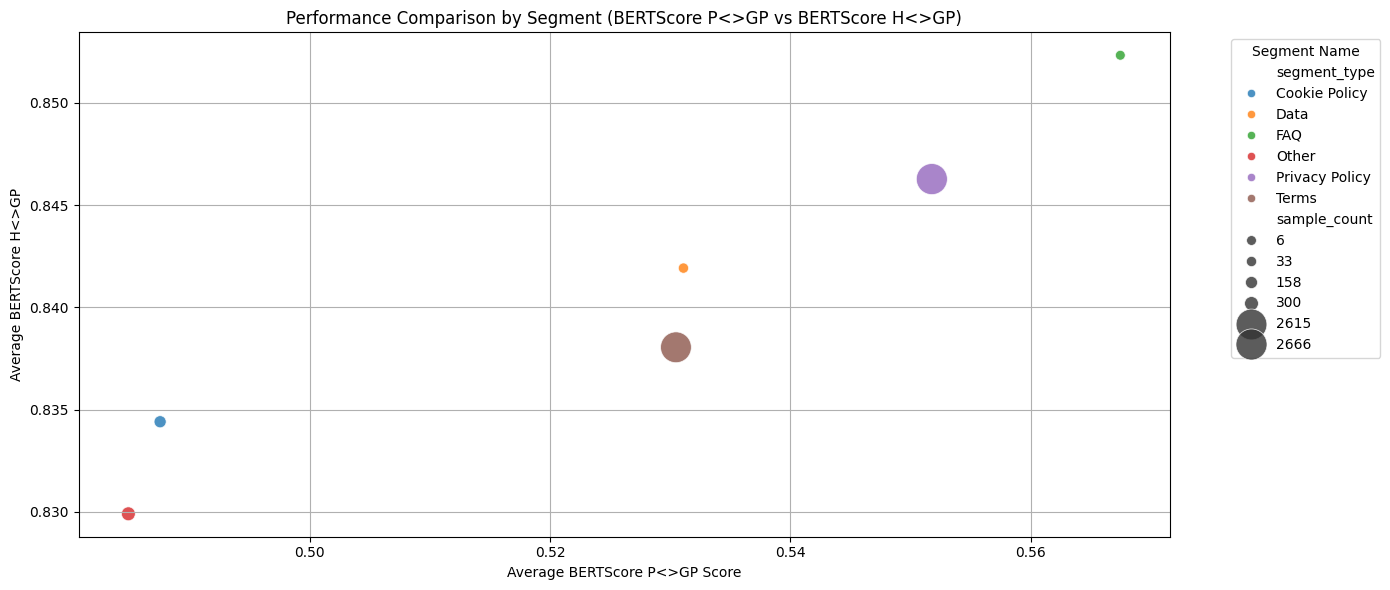

In [ ]:
# Count the number of rows (samples) per segment_name
segment_sample_counts = gen_analysis_df["segment_type"].value_counts().reset_index()
segment_sample_counts.columns = ["segment_type", "sample_count"]

# Calculate the mean scores for each segment
segment_performance = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Merge the sample counts with performance data
segment_performance = segment_performance.merge(segment_sample_counts, on="segment_type")

# Plot performance comparison
plt.figure(figsize=(14, 6))

# Scatter plot with sample count as marker size
sns.scatterplot(
    data=segment_performance,
    x="BERTScore P<>GP",
    y="BERTScore H<>GP",
    size="sample_count",
    hue="segment_type",
    sizes=(50, 500),
    alpha=0.8
)

plt.title("Performance Comparison by Segment (BERTScore P<>GP vs BERTScore H<>GP)")
plt.xlabel("Average BERTScore P<>GP Score")
plt.ylabel("Average BERTScore H<>GP")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

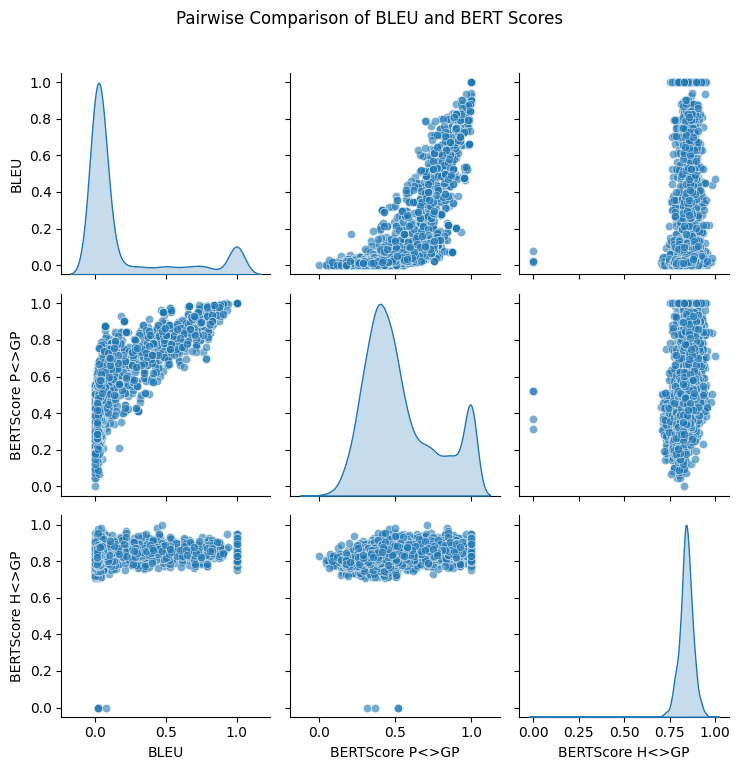

In [ ]:
# Create a pairplot to compare BLEU, BERTScore P<>GP, and BERTScore H<>GP
sns.pairplot(
    gen_analysis_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]],
    kind="scatter",
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)

plt.suptitle("Pairwise Comparison of BLEU and BERT Scores", y=1.02)
plt.tight_layout()
plt.show()

# Next Steps

1. X Pull more training data (195 services)
2. Clean highlight (punctuation, spaces, etc.) the same as done in TOS
3. Adjust Model

  a. Number of Epochs (currently 3)

  b. Adjust learning rate
  
  c. Adjust Batch Size (currently 4)
  
  d. Adjust Token Limit (currently 128)
4. X Evaluate based on different segments (privacy policies, FAQ, etc)
5. X Add context to the statement ("paraphrase this privacy policy statement: " + highlight) - look at t5 prompts that work
6. X Use a larger model or find a domain specific model (t5, pegasus, gpt)
7. X Use BERT score against the original to retry
8. Ensemble Models
9. Check factual consistency

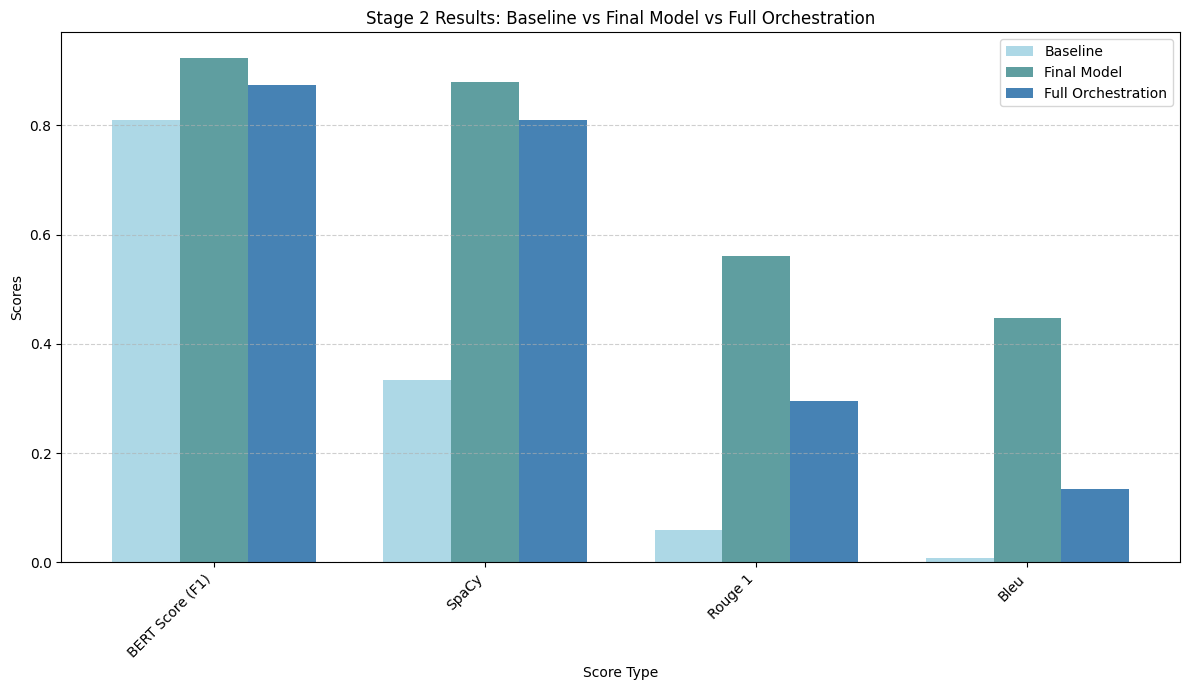

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
score_types = ["BERT Score (F1)", "SpaCy", "Rouge 1", "Bleu"]
baseline_scores = [0.810, 0.334, 0.059, 0.009]
final_model_scores = [0.924, 0.880, 0.560, 0.447]
full_orchestration_scores = [0.873, 0.810, 0.296, 0.134]

# X-axis positions for the groups
x = np.arange(len(score_types))

# Width of the bars
width = 0.25

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x - width, baseline_scores, width, label='Baseline', color = "lightblue")
ax.bar(x, final_model_scores, width, label='Final Model', color = "cadetblue")
ax.bar(x + width, full_orchestration_scores, width, label='Full Orchestration', color = "steelblue")

# Adding labels, title, and legend
ax.set_xlabel('Score Type')
ax.set_ylabel('Scores')
ax.set_title('Stage 2 Results: Baseline vs Final Model vs Full Orchestration')
ax.set_xticks(x)
ax.set_xticklabels(score_types, rotation=45, ha='right')
ax.legend()

# Adding grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Display the chart
plt.tight_layout()
plt.show()